In [10]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
import matplotlib.pyplot as plt
file = '../test_data/test.jpeg'

In [3]:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
    
    image = cv2.imread(file)
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


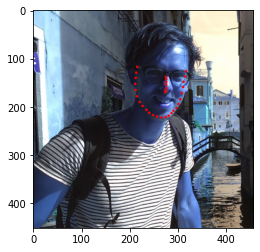

In [18]:
background = image.copy()
vidx = [389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377,  # contour
        152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162,
        94, 19, 1, 4, 5, 195, 197, 6]
for i in vidx:
    lm = results.multi_face_landmarks[0].landmark[i]
    x = int(lm.x * image.shape[0])
    y = int(lm.y * image.shape[0])

    cv2.circle(background, center=(x, y), radius=1, thickness=2, color=(255, 0, 0))
    
plt.imshow(background)